In [3]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [42]:
df = pd.read_excel('/Users/rraj/Desktop/GlomData/GlomData_clean.xls', sheet_name='GIA0512')
df_stats = df.describe()
df_stats

,HXH,HXH.1,HXH.2,PTO,PTO.1,PTO.2,AA,AA.1,AA.2,PNE,...,IPBE.2,CNO,CNO.1,CNO.2,BTN,BTN.1,BTN.2,IMA,IMA.1,IMA.2
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.0,...,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.000123,0.010972,0.034009,0.000384,0.003456,0.014865,0.0,0.002500,0.013889,0.0,...,0.033971,0.000164,0.001754,0.013031,0.0,0.001294,0.011643,0.000563,0.012534,0.088809
std,0.001239,0.012543,0.025098,0.002776,0.009573,0.016028,0.0,0.006523,0.013267,0.0,...,0.025061,0.001660,0.004551,0.023071,0.0,0.007214,0.015400,0.003875,0.012821,0.034770
min,0.000000,0.000000,0.010646,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.022093
25%,0.000000,0.000000,0.017662,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.014291,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.068471
50%,0.000000,0.010856,0.024783,0.000000,0.000000,0.014939,0.0,0.000000,0.012550,0.0,...,0.027907,0.000000,0.000000,0.005127,0.0,0.000000,0.010290,0.000000,0.012386,0.085428
75%,0.000000,0.015549,0.040857,0.000000,0.000000,0.022933,0.0,0.000000,0.017588,0.0,...,0.047030,0.000000,0.000000,0.016776,0.0,0.000000,0.016868,0.000000,0.018138,0.106025
max,0.012509,0.063781,0.128328,0.023162,0.074673,0.069774,0.0,0.029513,0.077070,0.0,...,0.117362,0.016765,0.020428,0.124436,0.0,0.064051,0.067770,0.036457,0.062720,0.199837


In [43]:
from typing import List

def label_to_idx(labels: List[str]):
    prev_label = ' '
    prev_idx = -1
    idx = []
    for label in labels:
        if prev_label[:3] not in label:
            prev_label = label
            prev_idx += 1
        idx.append(prev_idx)
    return idx

idxs = label_to_idx(list(df.columns))
labels_to_idx_dict = {label: idx for idx, label in zip(idxs, list(df.columns))}

In [44]:
df = df.T
df = df[df_stats.T['mean'] > 0.002]
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)
print(f"train_size={train_df.size//102}, test_size={test_df.size//102}")

train_size=89, test_size=10


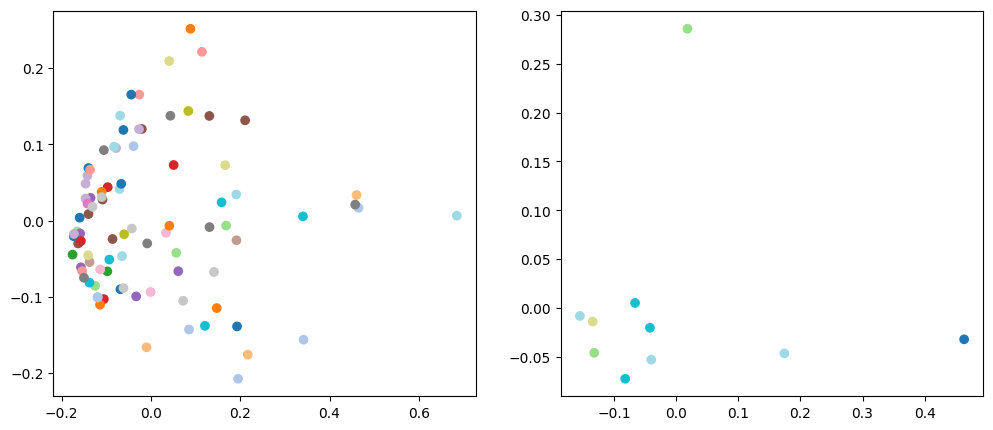

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
train_projections = pca.fit_transform(train_df)
test_projections = pca.fit_transform(test_df)

train_targets = [labels_to_idx_dict[label] for label in list(train_df.index)]
test_targets = [labels_to_idx_dict[label] for label in list(test_df.index)]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(train_projections[:,0], train_projections[:,1], c=train_targets, cmap='tab20')
ax[1].scatter(test_projections[:,0], test_projections[:,1], c=test_targets, cmap='tab20')

In [46]:
import torch
from torch.utils.data import Dataset
from typing import Dict


class OlfactoryData(Dataset):
    def __init__(self, data: pd.DataFrame, labels_to_idx_dict: Dict):
        self.data = data.values
        self.labels = [labels_to_idx_dict[label] for label in list(data.index)]
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        sample = torch.tensor(self.data[index,:]).float()
        return sample, self.labels[index] 


train_data = OlfactoryData(train_df, labels_to_idx_dict)
test_data = OlfactoryData(test_df, labels_to_idx_dict)

In [62]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output, display
from typing import Dict, List


class ProjectionPlotter:
    def __init__(self, nplots: int, layout: tuple = None):
        self.nplots = nplots
        self.layout = layout
        self.pca = PCA(n_components=2)
        self.loss = []
        self._initialize_fig()
        
        
        
    def __call__(self, activations: Dict, targets: List[int], loss: int):
        assert len(activations) == self.nplots - 1
        assert len(targets) == activations[0].shape[0]
        self.loss.append(loss)
        
        for i in range(1, self.nplots):
            projections = self._transform(activations[i-1])
            self._scatter(vars(self)['ax'+str(i)], projections, targets)
        self._plot(vars(self)['ax'+str(self.nplots)], self.loss)
        
        clear_output(wait=True)
        display(self.fig)
    
    @staticmethod 
    def _scatter(axis, projections: torch.Tensor, targets: List[int]):
        axis.clear()
        axis.scatter(projections[:,0], projections[:,1], c=targets, cmap='tab20')
    
    @staticmethod   
    def _plot(axis, loss: List):
        axis.clear()
        axis.plot(loss)
    
    def _transform(self, data: torch.Tensor):
        self.pca.fit(data.numpy())
        components = torch.tensor(self.pca.components_)
        projections = torch.mm(data, components.T)
        return projections

    def _initialize_fig(self):
        if self.layout is None:
            self.layout = (1, self.nplots)
        self.fig = plt.figure(figsize=(6*self.layout[1],5*self.layout[0]))
        for i in range(1, self.nplots+1):
            vars(self)['ax'+str(i)] = self.fig.add_subplot(*self.layout, i)
        plt.close(self.fig)
    

In [63]:
import transformations
from layers import DiscriminationModule, AdaptationModule
from initialization import RandomInitializer, IdentityInitializer
from loading import TripletLoader
from transformations import AddNoise, ToVector, Scale
from testing import TestModule

transforms = transformations.Compose([Scale(), ToVector()])
train_loader = TripletLoader(train_data, transforms=transforms)
test_module = TestModule()

out_dim = 100

layer1 = DiscriminationModule(out_dim, RandomInitializer(102))
layer2 = AdaptationModule(out_dim, IdentityInitializer(), lr=0.01)
layer3 = AdaptationModule(out_dim, IdentityInitializer(), lr=0.01)

plotter = ProjectionPlotter(4)

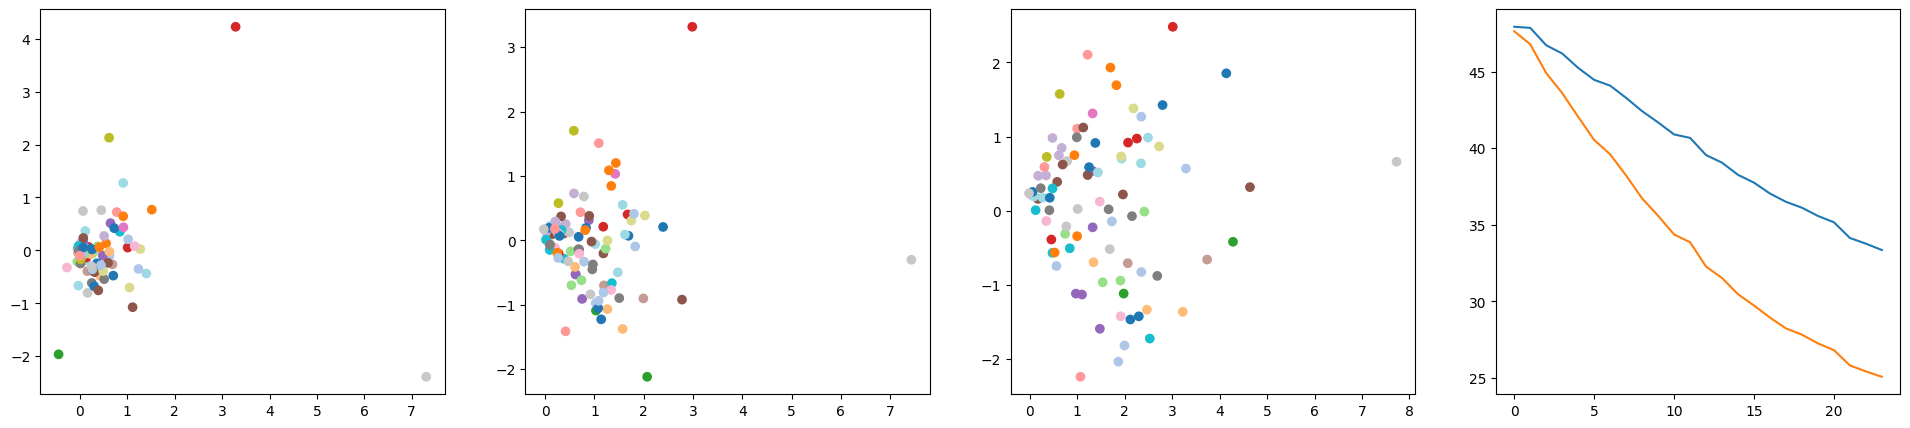

Epoch:25/30:  32%|███▏      | 16/50 [00:20<00:43,  1.28s/it]

In [64]:
from tqdm import tqdm

nepochs = 30
nbatches = 50
batch_size = 55
for epoch in range(nepochs):
    batch_loss1, batch_loss2 = 0.0, 0.0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        for x in train_loader(batch_size):
            x = layer1(x)
            x = layer2(x)
            x = layer3(x)
            
        batch_loss1 += layer2.loss/batch_size
        batch_loss2 += layer3.loss/batch_size
        
        layer1.organize()
        layer2.organize()
        layer3.organize()
        
    test_outputs, targets = test_module([layer1, layer2, layer3], test_dataset=train_data, input_transforms=transforms)
    plotter(test_outputs, targets, [batch_loss1, batch_loss2])